## Open Quantum Systems with Dynamic Circuits on Amazon Braket with IQM

Dynamic circuits allow for varied applications between a quantum system and its environment, describing a complex open quantum system. Mid-circuit measurements allows for non-unitary operations to take place, and feedforward operations allow us to make adjustments on a target state, allowing us to stabilize or even correct data qubits. 

In this notebook we consider examples broadly related to open quantum systems, including non-unitary state evolutions and mixed state preparations. 

### Notebook Setup

Before we dive into our examples, let's (again) handle our imports. For simplicity, we will work here with standard Clifford gates, Pauli rotations, and `cc_x` or `cc_z` primitives. The `cc_x` gate (and by a simple rotation `cc_z`) applies an X gate conditionally on a particular measurement configuration.

In the local simulator, we use a composition of a partial trace and initialization procedure, which are both valid quantum channels and thus can be implemented through their Kraus operators ($\mathcal{E}[\rho]=  \sum K_i \rho K_i^\dagger$):

$$K_0= |0\rangle \langle 0 | \otimes I $$

$$ K_1 = |0 \rangle \langle 1 | \otimes X $$

Notes on `iqm_config.py` and `local_config.py`:
- `cc_x` and `cc_z` are *user defined* gate types. Use the `reset` keyword to specify an active reset. 
- These gates assume that `measure_ff` and any `cc_prx` are implemented at the same layer and time, and can be concatenated as `cc_x`.
- Importing `iqm_config.py` transpiles Clifford circuits to native IQM gates.
- For actual implementations, see the respective `iqm_config.py` or `local_config.py` files.

In [1]:
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np

from braket.circuits import Circuit
from braket.experimental_capabilities import EnableExperimentalCapability
from braket.tracking import Tracker

In [2]:
use_qpu = True

if use_qpu: 
    import iqm_config
    qd = iqm_config.qd
else:
    import local_config
    qd = local_config.qd

track = Tracker().start()

def calc_z_exp(counts : dict, qubits : list) -> float:
    """ calculate z_expectations from shots on particular qubits """
    val = 0
    for k,v in counts.items():
        val+= v*(-1)**len([k[i] for i in qubits if k[i]=="1"])
    return val/sum(list(counts.values()))


### Simulating Amplitude Damping (Relaxation) Processes

Open quantum systems describe quantum systems in the presence of environmental noise sources, which serve to modify the pure state dynamics. In many contexts, these can be desirable in creating thermal states or simulating realistic systems. 

In this example, we repeatedly apply a non-unital channel, the single qubit amplitude damping channel, using a single ancilla qubit. The amplitude damping channel (related to a quantum system's $T_1$ decay) can be described by relaxing (via a bit-flip) a quantum state with probability $p$ *if* the qubit is in the excited state, and the Kraus operator formalism involves two operators:

$$ K_0 = \begin{pmatrix} 1 & 0 \\ 0 & \sqrt{1-p} \end{pmatrix},~ K_1 = \begin{pmatrix} 0 & \sqrt{p} \\ 0 & 0 \end{pmatrix} $$ 

but we can implement this with unitary operators using controlled $R_y$ gates and a feedback. We first apply a controlled $R_y$ gate from the data qubit to the ancilla qubit to rotate between the $10$ and $11$ state. We then measure the ancilla (which returns $1$ with probability $p$ times the excited population) and use a classical feedforward $X$ gate to flip the qubit. The following example plots the qubit population as a function of time. More details on the unitary implementation can be seen [here](https://arxiv.org/pdf/2001.00794).  




In [3]:
iters = 10

qreg = [1,2]
population = []
p = 0.5

results = []

with EnableExperimentalCapability():

    for i in range(iters+1):
        circ = Circuit()
        circ.x(qreg[0])
        for j in range(i):
            # implements controlled Ry (not X Ry(z) X = Ry(-z))  
            circ.ry(qreg[1],np.arcsin(np.sqrt(p)))
            circ.cnot(qreg[0],qreg[1])
            circ.ry(qreg[1],-np.arcsin(np.sqrt(p)))
            circ.cnot(qreg[0], qreg[1])

            circ.cc_x([qreg[1], qreg[0]])
        
        if use_qpu: 
            circ = Circuit().add_verbatim_box(circ)
        results.append(qd.run(circ, shots=100).result())
        population.append(0.5-0.5*calc_z_exp(results[-1].measurement_counts, [0]))

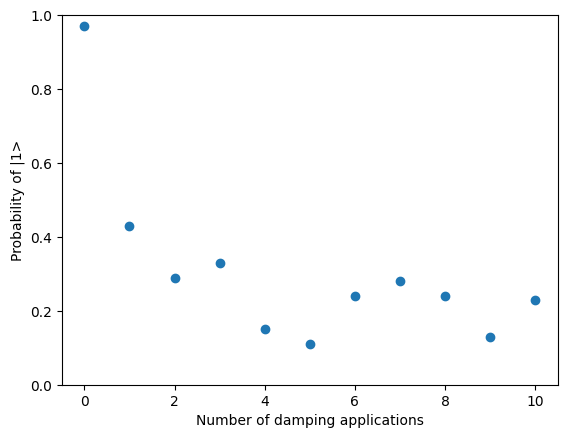

In [4]:
plt.scatter(list(range(iters+1)),population)
plt.xlabel("Number of damping applications")
plt.ylabel("Probability of |1>")
plt.ylim(0,1)
plt.show()

### Ensemble State Preparation 

Another application involves preparing an ensemble state, which can be used in thermal state preparation, or in the optimization of ensembles (see this [reference](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.1.033062)). Here we simply prepare two of four qubits in the maximally mixed state. Note, any unitaries acting only on these qubit will be trivial, but we can remove the non triviality by operating between the remaining two qubits. 

Typically, one would create a GHZ state between each qubit and the register, requiring $N$ entangling gates. Using MCM we only need a single qubit, and we iterate over the targeted qubits (here 5,6). 

In [5]:
qreg = [5,6,7,12,11]

with EnableExperimentalCapability():
    circ = Circuit()
    for q in [qreg[1],qreg[0]]:
        circ.h(qreg[4])
        circ.cc_x([qreg[4],q]) 


    if use_qpu: 
        circ = Circuit().add_verbatim_box(circ)

    circ.measure(qreg[:4])
    res0 = qd.run(circ, shots=500).result()

/var/folders/1_/bfh8x9qn75164y0b808mvhrh0000gq/T/ipykernel_44833/128448190.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


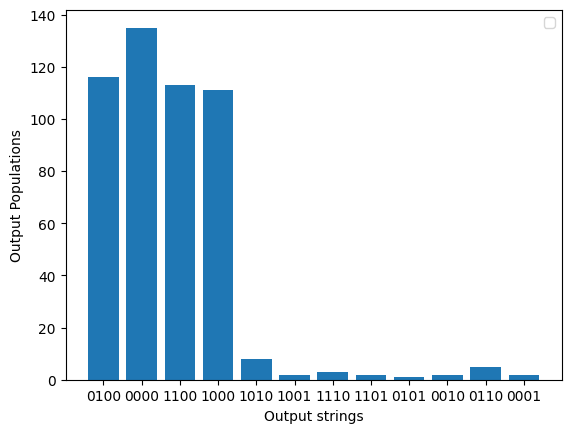

In [6]:
counts = res0.measurement_counts
plt.bar(counts.keys(), counts.values())
plt.legend(loc='upper right')
plt.ylabel("Output Populations")
plt.xlabel("Output strings")
plt.show()

We can somewhat naively verify that these are not prepared coherently by looking at the $Z$ and $X$ expectations throughout the circuit. For a coherent superposition, we would expect some $Z$ observables to be non-zero, whereas $X$ should all be equal to 0.

In [9]:
qreg = [5,6,7,12,11]

with EnableExperimentalCapability():
    circ = Circuit()
    for q in [qreg[1],qreg[0]]:
        circ.h(qreg[4])
        circ.cc_x([qreg[4],q]) 

    for q in qreg[:4]:
        circ.h(q)

    if use_qpu: 
        circ = Circuit().add_verbatim_box(circ)
    circ.measure(qreg[:4])

    res1 = qd.run(circ, shots=1000).result()    

Here, we can see that the expectations involving the mixed qubits (0,1) are zero, while expectations on the pure qubits (2,3) are 1 for $Z$ (or 0 for $X$). 

Expectation Values for different Z (X) Pauli strings: 
Site: (0,)      | Expected: 0.0 (0.0) | Measured: +0.044 (+0.014)
Site: (1,)      | Expected: 0.0 (0.0) | Measured: +0.040 (+0.026)
Site: (2,)      | Expected: 1.0 (0.0) | Measured: +0.928 (+0.070)
Site: (3,)      | Expected: 1.0 (0.0) | Measured: +0.972 (+0.098)
Site: (0, 1)    | Expected: 0.0 (0.0) | Measured: +0.028 (+0.012)
Site: (0, 2)    | Expected: 0.0 (0.0) | Measured: +0.060 (+0.004)
Site: (0, 3)    | Expected: 0.0 (0.0) | Measured: +0.048 (+0.008)
Site: (1, 2)    | Expected: 0.0 (0.0) | Measured: +0.032 (+0.024)
Site: (1, 3)    | Expected: 0.0 (0.0) | Measured: +0.036 (-0.012)
Site: (2, 3)    | Expected: 1.0 (0.0) | Measured: +0.900 (+0.044)
Site: (0, 1, 2) | Expected: 0.0 (0.0) | Measured: +0.060 (-0.030)
Site: (0, 1, 3) | Expected: 0.0 (0.0) | Measured: +0.024 (+0.014)
Site: (0, 2, 3) | Expected: 0.0 (0.0) | Measured: +0.064 (-0.006)
Site: (1, 2, 3) | Expected: 0.0 (0.0) | Measured: +0.028 (-0.018)


(-1.1, 1.1)

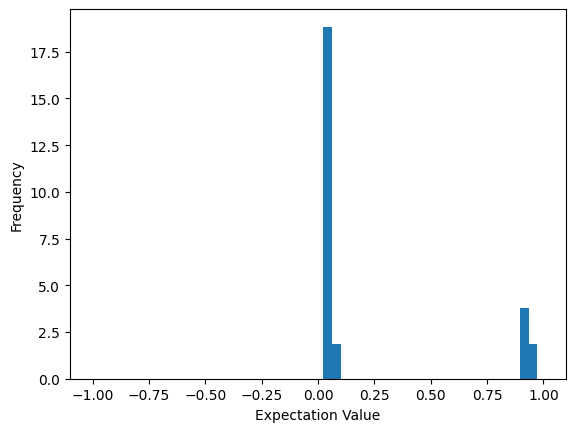

In [ ]:
temp : list[list] = []
for order in range(3): 
    temp.extend(combinations([0, 1, 2, 3], order+1))
res0_z = [calc_z_exp(res0.measurement_counts, list(qbs)) for qbs in temp]
res1_x = [calc_z_exp(res1.measurement_counts, list(qbs)) for qbs in temp]

print("Expectation Values for different Z (X) Pauli strings: ")
for t,rz,rx,site in zip(temp, res0_z, res1_x, temp):
    if 0 in t or 1 in t:
        print(f"Site: {str(site):<10}| Expected: 0.0 (0.0) | Measured: {rz:+0.3f} ({rx:+0.3f})")
    else:
        print(f"Site: {str(site):<10}| Expected: 1.0 (0.0) | Measured: {rz:+0.3f} ({rx:+0.3f})")

plt.hist(res0_z, bins=25, density=True)
plt.hist
plt.xlabel("Expectation Value")
plt.ylabel("Frequency")
plt.xlim(-1.1,1.1)

### Cost Estimate

And finally let's look at our cost estimate for these runs on IQM Garnet:

In [13]:
if use_qpu: 
    print("Quantum Task Summary")
    print(track.quantum_tasks_statistics())
    print(
        "\nNote: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage.\nEstimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits,\nand you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).",
    )
    print(
        f"\nEstimated cost to run this example: {track.qpu_tasks_cost() + track.simulator_tasks_cost():.3f} USD",
    )

Quantum Task Summary
{<_IQM.Garnet: 'arn:aws:braket:eu-north-1::device/qpu/iqm/Garnet'>: {'shots': 2600, 'tasks': {'COMPLETED': 13}}}

Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage.
Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits,
and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).

Estimated cost to run this example: 7.670 USD


### Conclusions

In this notebook we explored applications of open quantum systems and mixed state prepartion techniques using dynamic circuits. Dynamic circuits allow for flexible ways to harness dilations of quantum state space, allowing us to efficiently prepare mixed states or apply non-unitary operators with reduced qubit counts. Numerous advanced applications for dynamic circuits already exist, and research for various dynamic circuit-based approaches is ongoing. 




### References: 
1. Zhou, Leung, Chaun. *Methodology for quantum logic construction* (2000) [arXiv:quant-ph/0002039](https://arxiv.org/pdf/quant-ph/0002039).
2. Buhrman, Folkertsma, Loff, Nuemann. *State preparation by shallow circuits using feed forward* (2024) [Quantum 8, 1552](https://quantum-journal.org/papers/q-2024-12-09-1552/).
3. Rost, Jones, Vyushkova et al. Simulation of Thermal Relaxation in Spin Chemistry Systems on a Quantum
Computer Using Inherent Qubit Decoherence (2020) [arXiv:2001.00794v2](https://arxiv.org/pdf/2001.00794). 
4. Amplitude Damping Channel, (Novebmer 24, 2023) In Wikipedia. https://en.wikipedia.org/wiki/Amplitude_damping_channel 
5. Nakanish, Mitarai, Fujii. *Subspace-search variational quantum eigensolver for excited states* (2019) [Phys. Rev. Res. 1, 033062](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.1.033062). 

